In [2]:
import os 
import h5py 
import numpy as np 
import matplotlib.pyplot as plt
import torch 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [18]:
! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  1218k      0 --:--:--  0:04:40 --:--:-- 1350k:--  0:01:10 --:--:--  386k:--  0:03:00 --:--:-- 2427k
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_

In [4]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


In [5]:
# we standardize the data, so that the mean is = 0 and rms = 1
from sklearn.preprocessing import StandardScaler
print(np.mean(features[:,10]), np.var(features[:,10]))
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(np.mean(features[:,10]), np.var(features[:,10]))

0.08990890900131082 0.0013334328255667934
6.394884621840902e-19 1.0000000000000036


In [6]:
features_standard = features[np.argmax(target,axis=1)<2]
features_W = features[np.argmax(target,axis=1)==2]
features_Z = features[np.argmax(target,axis=1)==3]
features_t = features[np.argmax(target,axis=1)==4]
print(features_standard.shape, features_W.shape, features_Z.shape, features_t.shape)

(19908, 16) (10015, 16) (10037, 16) (10040, 16)


In [7]:
label_standard = target[np.argmax(target,axis=1)<2]
print(label_standard)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [8]:
from sklearn.model_selection import train_test_split

#split into training and test
X_learn, X_test, label_learn, label_test = train_test_split(features_standard, label_standard, test_size=0.2)
print(X_learn.shape, label_learn.shape, X_test.shape, label_test.shape)

#split the training dataset into training and validation
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.2)
print(X_train.shape, label_train.shape, X_val.shape,  label_val.shape, X_test.shape, label_test.shape)

del features_standard, label_standard, features, target, X_learn, label_learn

(15926, 16) (15926, 5) (3982, 16) (3982, 5)
(12740, 16) (12740, 5) (3186, 16) (3186, 5) (3982, 16) (3982, 5)


In [10]:
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

In [11]:
train_data_tensor = torch.tensor(X_train, dtype = torch.float32)
train_labels_tensor = torch.tensor(label_train, dtype = torch.long)

test_data_tensor = torch.tensor(X_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(label_test, dtype=torch.long)

val_data_tensor = torch.tensor(X_val, dtype = torch.float32)
val_labels_tensor = torch.tensor(label_val, dtype = torch.long)

#learn_data_tensor = torch.tensor(X_learn, dtype=torch.float32)
#learn_lables_tensor = torch.tensor(label_learn, dtype=torch.long)



In [12]:
train_dataset = TensorDataset(train_data_tensor)
test_dataset = TensorDataset(test_data_tensor)

val_dataset  = TensorDataset(val_data_tensor)
#learn_dataset = TensorDataset(learn_data_tensor, learn_labels_tensor)

batch_size = 128

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=True)

In [13]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,10),
            torch.nn.ReLU(),
            torch.nn.Linear(10,5),
            torch.nn.ReLU()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5,10),
            torch.nn.ReLU(),
            torch.nn.Linear(10,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16)
        )
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded 

In [14]:
model = AE().to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [15]:
summary(model)

Layer (type:depth-idx)                   Param #
AE                                       --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       272
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       170
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       55
│    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       60
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       176
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      272
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0

In [16]:
print(train_data_tensor)
train_data_tensor.shape

tensor([[ 3.0396, -4.9488, -1.2691,  ..., -0.9767, -1.3066, -0.9141],
        [-1.0538,  0.6335, -0.5953,  ...,  0.5943, -0.2507,  1.7292],
        [ 0.9979, -1.5553, -1.2324,  ..., -0.8002, -1.2817, -0.6358],
        ...,
        [-0.5626,  0.6223, -0.8184,  ...,  1.1042, -0.6574,  0.1525],
        [ 0.1399,  0.2777, -1.0697,  ...,  1.6642, -1.1127, -0.1721],
        [-0.7738,  0.6933,  0.2077,  ..., -0.7176,  0.1889,  0.9409]])


torch.Size([12740, 16])

In [17]:
for batch_data in train_loader:
    print(batch_data[0])
    break

tensor([[ 1.0556, -0.9533, -1.1560,  ..., -0.3914, -1.2116, -1.0996],
        [-0.8520,  0.6811, -1.0571,  ...,  1.7837, -0.8633,  0.7090],
        [ 1.9157, -2.5307, -1.2618,  ..., -0.4393, -1.3160, -1.1459],
        ...,
        [ 1.6572, -1.7258, -1.2221,  ..., -0.7479, -1.2891, -0.8677],
        [ 2.1179, -2.3092, -1.2110,  ..., -1.3880, -1.2688, -1.6560],
        [-0.4578,  0.2515, -1.0908,  ...,  1.8856, -1.1619,  0.2916]])


In [18]:
epochs = 200
loss_values = []
val_loss_values =[]
counter = 0

for epoch in range(epochs):
    running_loss = 0.0
    for batch_data in train_loader:
                
        optimizer.zero_grad()
        
        outputs = model(batch_data[0])
        loss = loss_function(outputs, batch_data[0])
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    with torch.no_grad():
        validation_loss = 0.0
        for val_batch_data in val_loader:

            val_outputs = model(val_batch_data[0])
            val_loss = loss_function(val_outputs, val_batch_data[0])
            validation_loss += val_loss.item()

        average_validation_loss = validation_loss / len(val_loader)
        
    loss_values.append(running_loss/ batch_size)  
    val_loss_values.append(average_validation_loss)
    # print(f"Epoch [{epoch+1}/{epochs}], "
    #       f"Training Loss: {loss.item():.4f}, "
    #       f"Validation Loss: {average_validation_loss:.4f}")
    
    if len(loss_values) > 2:
        if loss_values[-1] > loss_values[-2]:
            counter += counter 

        else: counter = 0

        if counter == 10:
            break
        
    


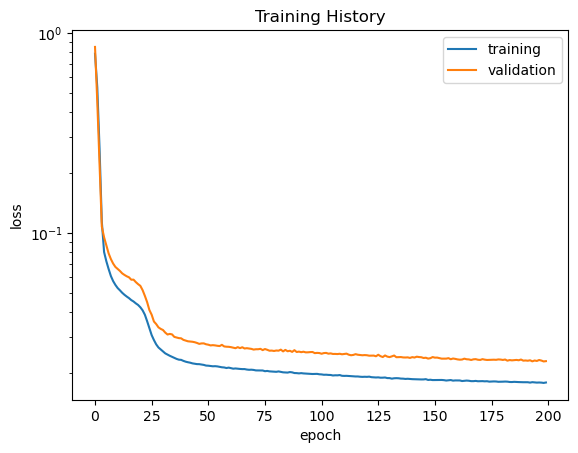

In [19]:
# plot training history
plt.plot(loss_values)
plt.plot(val_loss_values)
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [20]:
labels = ['W', 'Z', 'top']
features_W = torch.tensor(features_W, dtype=torch.float32)
features_Z = torch.tensor(features_Z, dtype=torch.float32)
features_t = torch.tensor(features_t, dtype=torch.float32)

In [21]:
anomaly = [features_W, features_Z, features_t]

with torch.no_grad():
    predictedQCD = model(test_data_tensor)
    predicted_anomaly = []
    for i in range(len(labels)):
        predicted_anomaly.append(model(anomaly[i]))

In [22]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    # sum over features
    mse = mse.sum(-1)
    return mse    

In [23]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

In [24]:
print(lossQCD.shape)

torch.Size([3982])


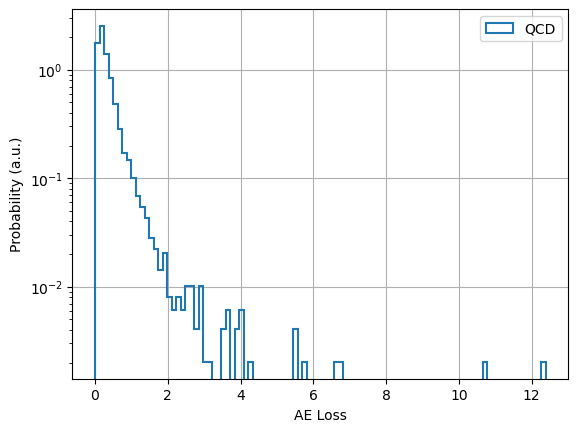

In [25]:
maxScore = np.max(lossQCD.numpy())
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

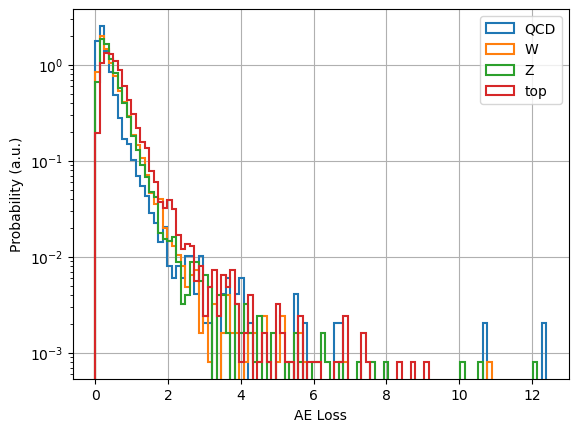

In [26]:
maxScore = np.max(lossQCD.numpy())
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

torch.Size([10015]) (3982,)
(13997,) (13997,)
torch.Size([10037]) (3982,)
(14019,) (14019,)
torch.Size([10040]) (3982,)
(14022,) (14022,)


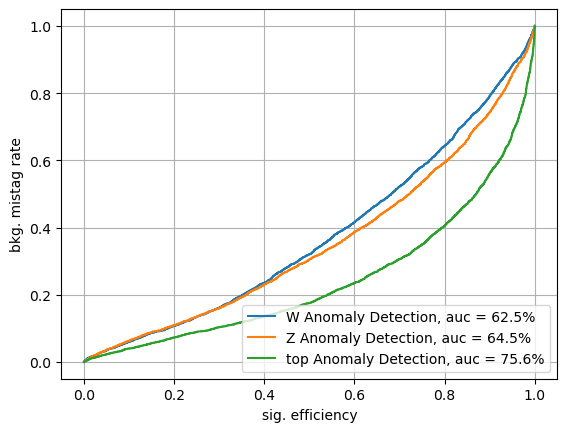

In [27]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
#plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()